## ECOMMERCE PRODUCT RECOMMENDATION SYSTEM WITH DEEP LEARNING
This is content based system suitable for new platforms or to avoid user privacy issues
We are going to extract image features using deep learning algorithm and feed the features to our similarity algorithm to produce recommendation

In [125]:
#loading the needed modules
import pandas as pd
import numpy as np
import re
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
import cv2
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import urllib.request 
from PIL import Image 
from matplotlib import pyplot as plt
%matplotlib inline

In [74]:
#load dataset
# the dataset is the recent Amazon sales dataset
df1= pd.read_csv('./data/Amazon/All_Appliances.csv')

In [4]:
pd.options.display.max_colwidth = 1000

In [75]:
df1.head(1)

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,"Pigeon by Stovekraft Amaze Plus Electric Kettle (14289) with Stainless Steel Body, 1.5 litre, used for boiling Water, maki...",appliances,All Appliances,https://m.media-amazon.com/images/W/IMAGERENDERING_521856-T1/images/I/51DGcy8eBCL._AC_UL320_.jpg,https://www.amazon.in/Pigeon-Amaze-Plus-1-5-Ltr/dp/B07WMS7TWB/ref=sr_1_1?qid=1679135585&s=appliances&sr=1-1,3.9,"128,941",₹599,"₹1,245"


In [76]:
df1['sub_category'].value_counts()

sub_category
All Appliances    9576
Name: count, dtype: int64

In [77]:
df1['image'].sample(4, random_state=6)

4951    https://m.media-amazon.com/images/I/51V47I32mtS._AC_UL320_.jpg
8470    https://m.media-amazon.com/images/I/31DnKSy2+2L._AC_UL320_.jpg
501     https://m.media-amazon.com/images/I/91-r79G7pIL._AC_UL320_.jpg
3573    https://m.media-amazon.com/images/I/4120Bn-FFoL._AC_UL320_.jpg
Name: image, dtype: object

In [9]:
df1['link'].sample(4, random_state=6)

4951       https://www.amazon.in/KBL-Portable-Electric-Rechargeable-Blender/dp/B09BVTDTPR/ref=sr_1_4952?qid=1679135873&s=appliances&sr=1-4952
8470       https://www.amazon.in/ZETONES-Electric-Cooking-Steamer-600-Watts/dp/B0BD99P39P/ref=sr_1_8495?qid=1679136069&s=appliances&sr=1-8495
501     https://www.amazon.in/akiara-Tailoring-Stitching-Scissors-Accessories/dp/B08ZXZ362Z/ref=sr_1_502?qid=1679135615&s=appliances&sr=1-502
3573              https://www.amazon.in/V-Guard-400-Plus-Voltage-Stabilizer/dp/B07C8MLRT5/ref=sr_1_3574?qid=1679135796&s=appliances&sr=1-3574
Name: link, dtype: object

In [126]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   asin_code       9576 non-null   object
 1   name            9576 non-null   object
 2   main_category   9576 non-null   object
 3   sub_category    9576 non-null   object
 4   image           9576 non-null   object
 5   link            9576 non-null   object
 6   ratings         9098 non-null   object
 7   no_of_ratings   9098 non-null   object
 8   discount_price  9214 non-null   object
 9   actual_price    9485 non-null   object
dtypes: object(10)
memory usage: 748.2+ KB


In [79]:
links= list(df1['link'])

### Data Cleaning

__Extracting product ASIN CODES from the links, this codes will serve as the unique identifiers for the products__

In [80]:
asin_no = [(links[i].split("/")[-2].replace("'", ""))for i in range(len(links))]

In [81]:
asin_no[:6]

['B07WMS7TWB',
 'B01LWYDEQ7',
 'B09185QH3C',
 'B0B61DSF17',
 'B01C8P29N0',
 'B07SPVMSC6']

In [82]:
df1.insert(0, 'asin_code', asin_no)

In [127]:
#df1['image'].sample(20)

In [83]:
df1.sample(1)

,asin_code,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
3777,B0BN2576GQ,"C (DEVICE) Lint Remover for Woolen Clothes, Electric Lint Remover, Best Lint Shaver for Clothes Pack of 1",appliances,All Appliances,https://m.media-amazon.com/images/I/61ipaZ-XjZL._AC_UL320_.jpg,https://www.amazon.in/DEVICE-Remover-Woolen-Clothes-Electric/dp/B0BN2576GQ/ref=sr_1_3778?qid=1679135808&s=appliances&sr=1-3778,3.7,102,₹399,₹999


__Fixing the image links that are not working. Some of the links to the image are not working and this links show that they contain <br> 'IMAGERENDERING' within. we are going to develop the code to remove this IMAGERENDING from the links and return a working link__

In [85]:
df1['image']= df1['image'].map(lambda x: x[:33] + x[67:] if "IMAGERENDERING" in x else x)
df1.sample(2)

,asin_code,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
4278,B0BST8BVNB,Aquafresh ro/water purifier cabinet/body for ro/reverse osmosis/uv system 12 litre storage with clamp hand tap,appliances,All Appliances,https://m.media-amazon.com/images/I/31IT3W6EiVL._AC_UL320_.jpg,https://www.amazon.in/Aquafresh-purifier-cabinet-reverse-osmosis/dp/B0BST8BVNB/ref=sr_1_4279_mod_primary_new?qid=1679135836&s=appliances&sbo=RZvfv%2F%2FHxDF%2BO5021pAnSA%3D%3D&sr=1-4279,5.0,2,"₹1,450","₹2,000"
5717,B09GYPGJXD,Candes 15 Litre Elentro 5 Star Rated Automatic Instant Storage Electric Water Heater with Special Metal Body Anti Rust Coa...,appliances,All Appliances,https://m.media-amazon.com/images/I/6186zy7cdeL._AC_UL320_.jpg,https://www.amazon.in/Candes-Automatic-Electric-Metal-Installation/dp/B09GYPGJXD/ref=sr_1_5742?qid=1679135917&s=appliances&sr=1-5742,3.0,4,"₹3,699","₹8,599"


In [128]:
df1['image'][0]

'https://m.media-amazon.com/images/I/51DGcy8eBCL._AC_UL320_.jpg'

In [88]:
#get the asin codes in a list
asin_codes1= list(df1.asin_code)
#get the image lisks in a list
image_links2= list(df1['image'])

### retrieving images

In [129]:
#### Retrieving the resource located at the URL 
# and storing it in the file name a.png 
url = image_links2[0] 
urllib.request.urlretrieve(url, "newproduct1.png") 

# Opening the image and displaying it (to confirm its presence) 
img = Image.open(r"newproduct1.png")
img.show()

### download the images
#### We are using 5000 images for this project to ease the process and for easier deployment

In [16]:
#### Retrieving images loacted at the URL 
image_links_5000= image_links2[:5300]
asin_codes_5000= asin_codes1[:5300]
id= 0
for url in image_links_small:    
    urllib.request.urlretrieve(url, f"./images/{asin_codes_5000[id]}.png")
    id = id+1) 

**Get the images path from the system**

In [130]:
#check the files
# Setting work directory
directory_path = r"./images"

# Initialize an empty list to store image files
image_files = []

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Add only image files with the '.png' extension
        if file.endswith('.png'):
            image_files.append(os.path.join(root, file))

# Print the number of image files found
print("Number of image files:", len(image_files))

Number of image files: 5215


__Get the product names/asin code__

This will be used to concat the path with the other entries so that each product path will correspond to the product details

In [95]:
asin_no = [(image_files[i].split("/")[-1].replace("'", "").replace(".png", "")) for i in range(len(image_files))]
asin_no= [(asin_no[i].split("\\")[-1])for i in range(len(asin_no))]
asin_no[:5]

['B0000AITPL', 'B0000AN3QI', 'B0007VJMM4', 'B000E5LE3S', 'B000LTOCSG']

In [97]:
#create a dataframe for the asin code and path
df2= pd.DataFrame()
df2['asin_code']= asin_no
df2['path']= image_files
df2.head(3)

,asin_code,path
0,B0000AITPL,./images\B0000AITPL.png
1,B0000AN3QI,./images\B0000AN3QI.png
2,B0007VJMM4,./images\B0007VJMM4.png


In [98]:
df2= df2.drop_duplicates(subset="asin_code", keep='last')

In [99]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5215 entries, 0 to 5214
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   asin_code  5215 non-null   object
 1   path       5215 non-null   object
dtypes: object(2)
memory usage: 81.6+ KB


In [100]:
df3= df1.merge(df2, how= 'inner', on= 'asin_code').drop_duplicates(subset="asin_code", keep='last')

In [132]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5214 entries, 0 to 5213
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   asin_code      5214 non-null   object
 1   name           5214 non-null   object
 2   main_category  5214 non-null   object
 3   sub_category   5214 non-null   object
 4   link           5214 non-null   object
 5   image          5214 non-null   object
dtypes: object(6)
memory usage: 244.5+ KB


In [102]:
df3.dropna(axis=1, inplace =True)

In [115]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5214 entries, 0 to 5213
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   asin_code      5214 non-null   object
 1   name           5214 non-null   object
 2   main_category  5214 non-null   object
 3   sub_category   5214 non-null   object
 4   link           5214 non-null   object
 5   path           5214 non-null   object
dtypes: object(6)
memory usage: 244.5+ KB


In [43]:
#save to a csv file
df3.to_csv("data_clean.csv", index= False)

In [104]:
df3=pd.read_csv('data_clean.csv')

In [105]:
def return_image_embedding(model,img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    curr_df = pd.DataFrame(preds[0]).T
    return curr_df

### Modelling

In [106]:
# define the model
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')

In [133]:
#test the function
img_path=np.random.choice(df3['image'])
return_image_embedding(model,img_path)

1/1 [==============================] - 1s 603ms/step


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.048703,0.211887,0.0,0.95728,0.322792,0.516638,0.087534,0.641246,0.0,0.495871,...,0.647992,0.22053,0.189543,0.0,0.171046,0.0,0.158005,0.007429,0.737407,0.28656


So the model works, now we can try it out on the entire dataset

In [54]:
images_path= df3['path']
embedding_df = pd.DataFrame()
for curr_img in tqdm(images_path):
    curr_df = return_image_embedding(model,curr_img)
    curr_df['image'] = curr_img
    embedding_df = pd.concat([embedding_df,curr_df],ignore_index=True)

  0%|          | 0/5214 [00:00<?, ?it/s]

1/1 [==============================] - 0s 178ms/step


In [135]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,image
0,0.421869,0.972156,0.231074,0.580574,0.349585,0.000000,0.521966,0.000000,0.251368,0.908029,...,0.000000,0.215612,0.000000,0.000000,0.019234,0.563566,1.213236,0.004976,1.838551,./images\B07NPBG1B4.png
1,0.924965,0.346094,1.143541,0.691350,1.024031,0.554847,1.222357,0.336077,0.072047,0.501391,...,0.643683,0.096854,0.026679,0.189732,3.122950,0.480474,0.000000,1.481136,0.436889,./images\B0BRXQD38T.png
2,0.118305,1.723017,0.000000,0.000000,0.133391,0.758658,0.678485,0.559853,0.558495,0.472221,...,0.168657,1.042062,1.075995,1.842583,0.000000,1.275058,0.047505,0.067104,1.652279,./images\B08TM71L54.png
3,0.218912,1.153924,0.307606,0.189672,0.074580,0.110255,0.000000,1.027779,0.445061,0.068434,...,0.533225,0.071688,0.025065,0.485135,1.007865,0.557141,0.043977,1.035540,0.374905,./images\B097XJQZ8H.png
4,0.088693,1.144427,0.000000,0.026421,1.252669,0.044264,0.074848,0.251106,0.234493,0.032867,...,0.168025,0.476214,0.049535,0.094050,0.072150,2.537318,0.035435,0.922986,2.155089,./images\B0073QGKAS.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,0.484653,0.383473,0.051470,0.000000,0.417177,0.077214,0.052073,0.859564,0.192623,0.148365,...,0.039727,0.001873,0.279649,1.701332,0.220730,0.221294,0.196316,0.080162,0.278062,./images\B09G1CQYTL.png
5210,0.121170,1.832230,0.005025,0.124686,0.816692,0.631112,0.007558,0.000000,0.425664,0.097519,...,0.401375,0.640987,0.216020,0.193990,0.045810,4.031185,0.000000,0.011694,0.813898,./images\B07PP41LNN.png
5211,0.068608,0.953705,0.103814,1.251993,0.410265,0.317761,1.954570,1.334543,0.008585,0.095560,...,1.055310,0.804871,0.000000,0.731034,0.237207,0.652632,0.084844,0.290772,1.773385,./images\B079KHFKW2.png
5212,0.000000,1.901168,0.287792,0.165672,0.000000,0.174242,0.780862,0.129446,0.528219,0.000000,...,0.909888,0.038501,0.216712,1.021135,0.000000,0.139864,0.029991,0.261545,0.197075,./images\B07M6XV9XG.png


In [116]:
#df3.drop('image', axis= 1, inplace= True)

In [117]:
df3= df3.rename(columns= {'path':'image'})

In [118]:
#merge with df5
df4= df3.merge(embedding_df, how='left',on= 'image')

In [119]:
df4.head(1)

,asin_code,name,main_category,sub_category,link,image,0,1,2,3,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,B07NPBG1B4,"AmazonBasics High Speed 55 Watt Oscillating Pedestal Fan, 400mm Sweep Length, White (Without Remote)",appliances,All Appliances,https://www.amazon.in/AmazonBasics-400mm-Pedestal-Remote-White/dp/B07NPBG1B4/ref=sr_1_73?qid=1679135589&s=appliances&sr=1-73,./images\B07NPBG1B4.png,0.421869,0.972156,0.231074,0.580574,...,0.006326,0.0,0.215612,0.0,0.0,0.019234,0.563566,1.213236,0.004976,1.838551


In [65]:
df4.to_csv('image_vec.csv', index=False)

In [120]:
#import cosine similarity
from sklearn.metrics.pairwise import cosine_distances,pairwise_distances,cosine_similarity
cosine_similarity_df = pd.DataFrame(cosine_similarity(df4.drop(['image','main_category','sub_category','name','link','asin_code'],axis=1)))

In [121]:
cosine_similarity_df

,0,1,2,3,4,5,6,7,8,9,...,5204,5205,5206,5207,5208,5209,5210,5211,5212,5213
0,1.000001,0.375802,0.417058,0.347245,0.327562,0.436770,0.358328,0.437185,0.409586,0.570910,...,0.436664,0.329802,0.383211,0.474102,0.358318,0.425913,0.418183,0.347758,0.376407,0.340770
1,0.375802,1.000001,0.355629,0.543227,0.380508,0.488860,0.547297,0.464330,0.399587,0.396704,...,0.485193,0.316294,0.372598,0.505057,0.299266,0.351458,0.330459,0.348618,0.437453,0.501331
2,0.417058,0.355629,1.000000,0.388620,0.508514,0.437012,0.363130,0.419406,0.555937,0.548064,...,0.321881,0.471887,0.331362,0.426190,0.356486,0.540760,0.428907,0.462424,0.464734,0.282875
3,0.347245,0.543227,0.388620,1.000001,0.415744,0.443584,0.448680,0.417896,0.446230,0.415646,...,0.384853,0.309068,0.364462,0.492227,0.341195,0.385563,0.310073,0.339693,0.519689,0.432961
4,0.327562,0.380508,0.508514,0.415744,1.000000,0.400482,0.579131,0.404430,0.407705,0.394802,...,0.410053,0.400713,0.423199,0.413711,0.298276,0.382855,0.398572,0.474935,0.498519,0.301622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,0.425913,0.351458,0.540760,0.385563,0.382855,0.345354,0.350359,0.334706,0.525384,0.600766,...,0.336077,0.545505,0.391027,0.386677,0.354820,1.000000,0.347141,0.380964,0.497611,0.335747
5210,0.418183,0.330459,0.428907,0.310073,0.398572,0.440380,0.345268,0.420688,0.482142,0.420639,...,0.305892,0.331254,0.308949,0.372558,0.413757,0.347141,1.000000,0.332966,0.420652,0.260339
5211,0.347758,0.348618,0.462424,0.339693,0.474935,0.450946,0.402701,0.440958,0.414479,0.372833,...,0.436110,0.416004,0.482090,0.414646,0.309632,0.380964,0.332966,1.000000,0.358071,0.285064
5212,0.376407,0.437453,0.464734,0.519689,0.498519,0.360165,0.502911,0.342877,0.471480,0.445973,...,0.389982,0.422070,0.408686,0.467975,0.350275,0.497611,0.420652,0.358071,1.000000,0.383642


### retrieving similiarities

In [122]:
cosine_similarity_df.iloc[25].nlargest(10+1)[1:]

4512    0.842515
1781    0.793195
4323    0.782445
4618    0.780585
1050    0.780425
1650    0.752147
4470    0.746795
1207    0.740518
473     0.738706
1202    0.737071
Name: 25, dtype: float32

### Generating Recommendation

In [69]:
#defining a function to show the image
def show_img(asin_code,name):
    img_path = './images/'+str(asin_code)+ ".png"
    im = cv2.imread(img_path)
    im = cv2.resize(im, (960, 540))
    plt.axis('off')
    plt.imshow(im[:,:,::-1])
    plt.title(name)
    plt.show()

-----------------------------------------------------------------------
Original Product:


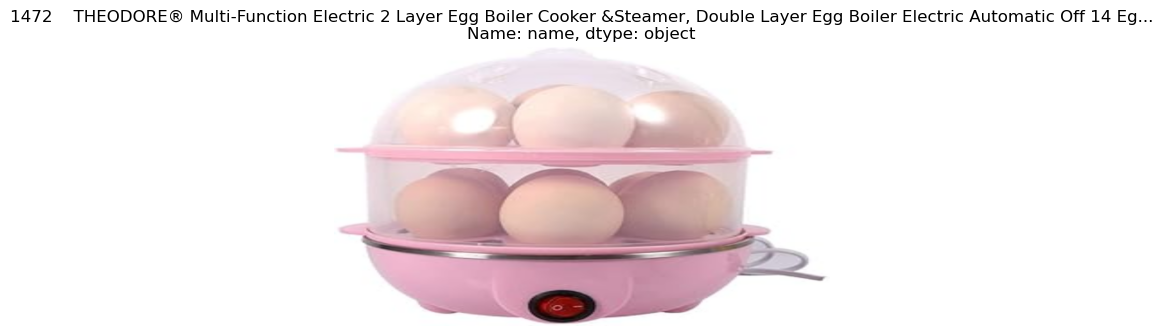

-----------------------------------------------------------------------
Recommended Product


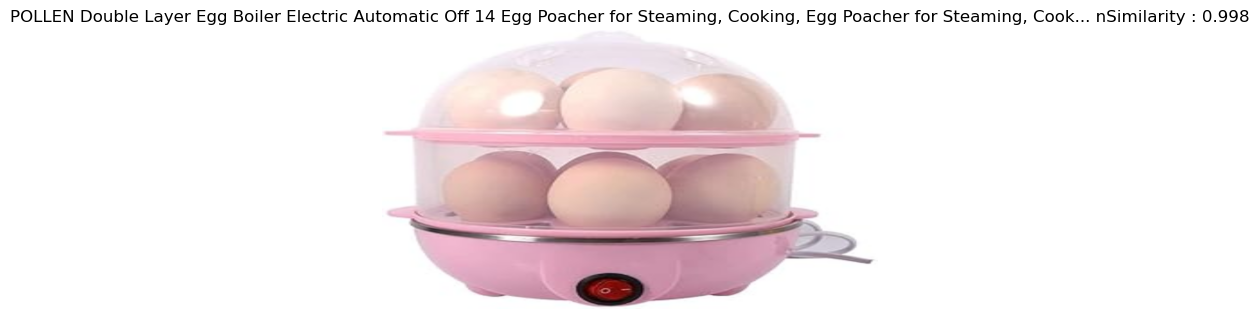

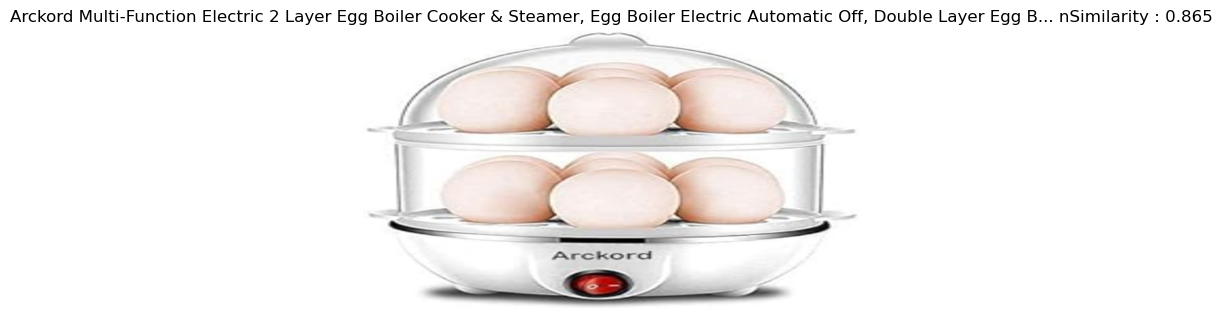

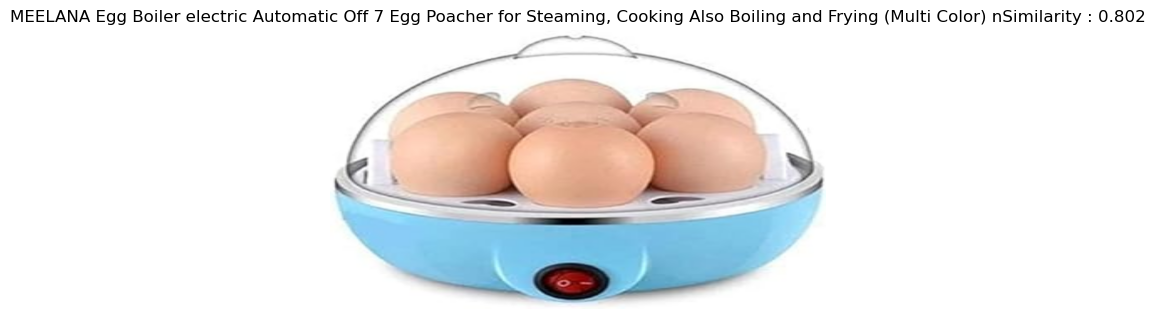

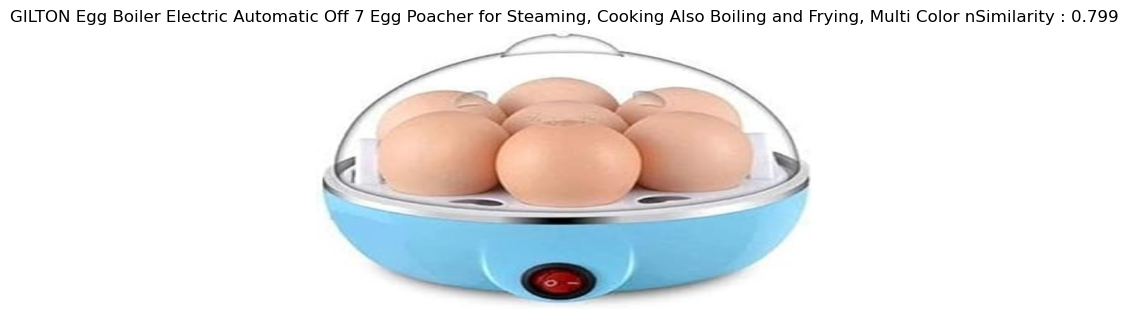

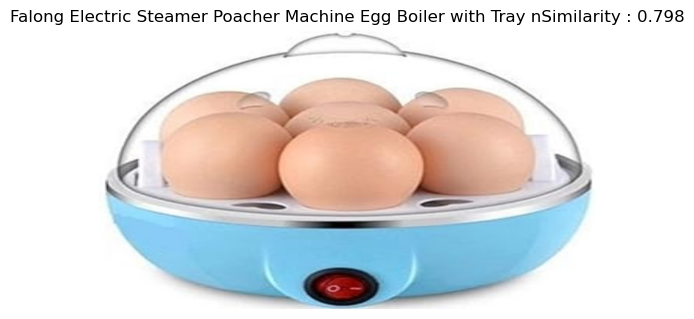

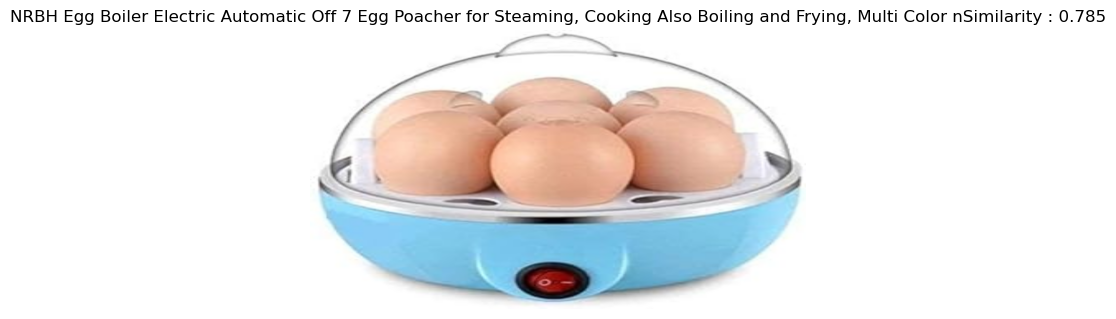

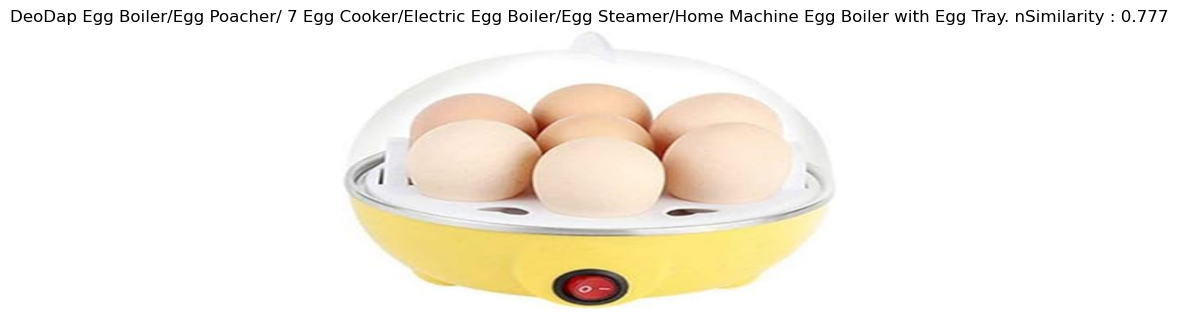

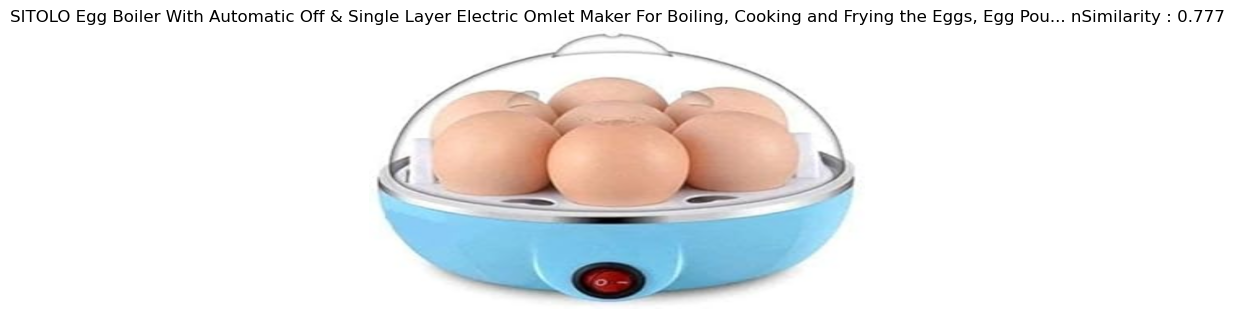

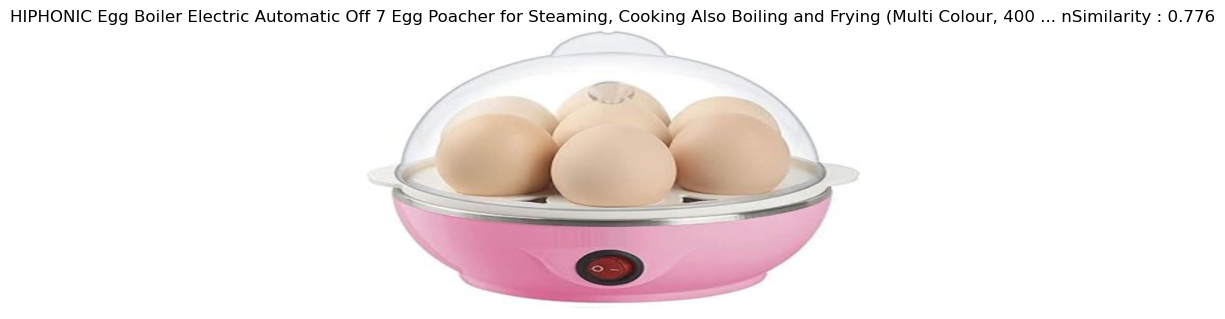

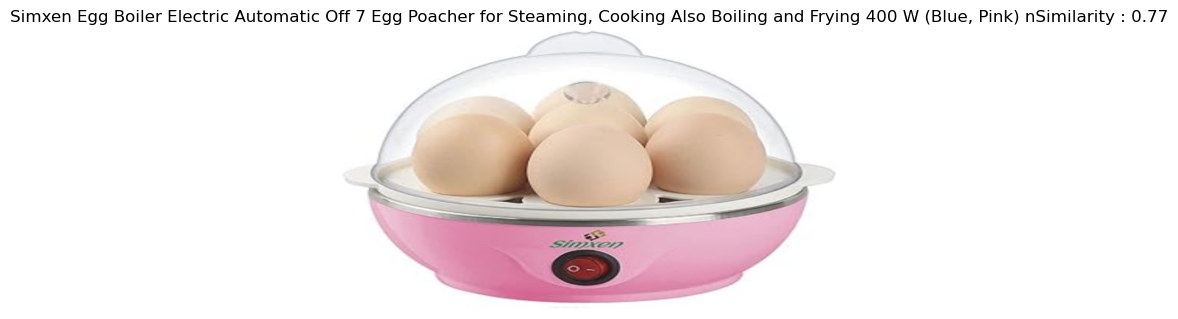

In [138]:
#defining a function to retrieve similar products 
def fetch_most_similar_products(asin_code, n_similar=10):
    print("-----------------------------------------------------------------------")
    print("Original Product:")
    img_path = './images\\'+str(asin_code)+ ".png"
    name_or= df4['name'][df4['asin_code']== asin_code]
    show_img(asin_code, name_or)
    curr_index = df4[df4['image']== img_path].index[0]
    closest_image = pd.DataFrame(cosine_similarity_df.iloc[curr_index].nlargest(n_similar+1)[1:])
    print("-----------------------------------------------------------------------")
    print("Recommended Product")
    for index,imgs in closest_image.iterrows():
        similar_image_asin = df4.iloc[index]['asin_code']
        name_rec= df4.iloc[index]['name']
        similarity = np.round(imgs.iloc[0],3)
        show_img(similar_image_asin,str(name_rec)+' nSimilarity : '+str(similarity))
image_name = np.random.choice(df4['asin_code'])
fetch_most_similar_products(image_name)